In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn. metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import seaborn as sns; sns.set()
import joblib
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
from pathlib import Path
import copy

#Trying out recusive feature elimination to compare with step wise regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import sklearn

from progressbar import ProgressBar



import datetime
import calendar


%matplotlib inline

#custom functions
def NSC(y_pred,y_true):
    """
    Nash-Sutcliffe Coefficient
    """
    return 1 - sum((y_pred-y_true)**2)/sum((y_true-np.mean(y_true))**2)




In [2]:

#This is the final dataset to make predictions on
p = Path('C:/Users/Ryan/Box/Dissertation/Paper1/Data/Processed_Training_Data')
#dir_data = 'C:/Users/Ryan/Box/Dissertation/Paper1/Data/Model_Input_Data/Monthly/Input/FinalVars'

slc = {i.stem[0:3] : pd.read_excel(i) for i in p.glob('**/*.xlsx')}

#rename the gpcd column
for i in slc:
    slc[i].rename(columns={i+'_gpcd': 'Obs_gpcd'}, inplace=True)
    slc[i]=slc[i].set_index('Year')
snow=pd.read_excel('C:/Users/Ryan/Box/Dissertation/Paper1/Data/Alta_LCC_snow.xlsx')
snow=snow.set_index('Year')
#need to remove certain features
'''
lots of colinearity between mountain and valley, since we are focused on the valley we will use valley conditions.
meantemp and maxtemps days > are good predictors, however, they will be difficult to predict into the future.
Mill creek and city creek show high colinarity. Since city creek is a source we will remove mill creek.
Removing red butte and emigration creeks as they are not supply streams and show co-linearity
!!! removing the aggregated Seven canyons streamflow. There appears to be a unique climate signial that very well helps
demand forecasting by including the supply streamflows!!!!
Precipitation days is removed as they will be difficult to predict with certainity in the future.
Days above max, mean is removed as its colinear with mean temp and is difficult to predict into future.
Percent are selected, sqmi is basicaly the same
Removed reshousingdensity at it is highly coorelated wiht respopulationdensity
removed Urban_Area_Perc as it has high colinearity with res pop dens
Residential_Area_Perc removed as colinear wiht res pop dens)
'''
colrem= ['Dem_AF', 'seven', 'meantemp_days', 'maxtemp_days', 'mean_max', 'mill', 'precip_days', 
         'Days_abovemax','Days_abovemean', 'red' , 'emig', 'sqmi','max_Days_WO',
         'mtn','ResHouseDensity', 'Urban_Area_Perc','Residential_Area_Perc', 'IrrPopulationDensity',
         'Irrigated_Area_Perc','CityCrk_AcFt_WR_Mar', 'LitCotCrk_AcFt_WR_Jun']#, 'AcFt', 'WO', 'days', 'days', 'above' , 'Perc']


for i in slc:
    for j in colrem:
        slc[i]=slc[i].loc[:,~slc[i].columns.str.contains(j , case=False)] 


In [3]:
#Create training and testing data, use most recent low, average, and high water years
slc_train=copy.deepcopy(slc)
slc_test=copy.deepcopy(slc)

#2008 is a high year
#2011 and 2017 are average years
#2014 and 2016 are below average years
#2015 is a very  low year

IN_WY_Months = ['Jan' , 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct']
Prior_YR_WY_Months = ['Nov', 'Dec']
testWYyrs = [2008,2015,2017]
#testPrioWYyrs = [2007,2014,2016]


for i in slc:
    #Select the training/testing dataframes
    slc_train[i]=slc_train[i][~slc_train[i].index.isin(testWYyrs)]
    slc_test[i]=slc_test[i][slc_test[i].index.isin(testWYyrs)]
   
    


In [4]:
    

#Determine the indoor mean to subtract from outdoor
I_mean_train=(slc_train['Jan']['Obs_gpcd']+
              slc_train['Feb']['Obs_gpcd']+
              slc_train['Mar']['Obs_gpcd']+
              slc_train['Nov']['Obs_gpcd']+
             slc_train['Dec']['Obs_gpcd'])/5
I_mean_test=(slc_test['Jan']['Obs_gpcd']+
             slc_test['Feb']['Obs_gpcd']+
             slc_test['Mar']['Obs_gpcd']+
             slc_test['Nov']['Obs_gpcd']+
             slc_test['Dec']['Obs_gpcd'])/5
#This uses total demand for irrigation seasons
#I_mean_train=np.zeros(23)
#I_mean_test=np.zeros(10)

for i in slc_train:
    slc_train[i]['Iave']=I_mean_train
    #for now include testing years
    slc_test[i]['Iave']=I_mean_test

IrrSeason= ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
Indoor=['Jan', 'Feb', 'Mar', 'Nov', 'Dec']
colrem=['Iave', 'Obs_gpcd']
#set the target gpcd to indoor for indoor and total-indoor for outdoor
#change to indoor to separate outdoor demands from total
for i in Indoor:
    slc_train[i]['Target_gpcd']=slc_train[i]['Obs_gpcd']
    slc_train[i]= slc_train[i].drop(columns=colrem)
    #for now include testing years
    slc_test[i]['Target_gpcd']=slc_test[i]['Obs_gpcd']
    slc_test[i]= slc_test[i].drop(columns=colrem)
    

#Establish outdoor conservation thresholds
O_cons = 0.25
time = 20


for i in IrrSeason:
    slc_train[i]['Target_gpcd']=slc_train[i]['Obs_gpcd']-slc_train[i]['Iave']
    slc_train[i].loc[slc_train[i]['Target_gpcd'] < 0, 'Target_gpcd'] = 0
    
    #add in snow info
    slc_train[i]=pd.concat([slc_train[i], snow], axis=1, join="inner")
    
    slc_train[i]= slc_train[i].drop(columns=colrem)
    #for now include testing years
    slc_test[i]=pd.concat([slc_test[i], snow], axis=1, join="inner")
    slc_test[i]['Target_gpcd']=slc_test[i]['Obs_gpcd']-slc_test[i]['Iave']
    slc_test[i].loc[slc_test[i]['Target_gpcd'] < 0, 'Target_gpcd'] = 0
    
    #create monthly historical mean and conservation trends
    Out_mean = np.mean(slc_train[i]['Target_gpcd'].loc[2000:])
    goal = (1-O_cons)*Out_mean
    O_cons_rate = (Out_mean -goal)/time
    


    slc_train[i]['cons_goal'] = Out_mean- ((slc_train[i].index-2000)*O_cons_rate)
    slc_train[i].loc[ slc_train[i].index <2000, ['cons_goal']] = Out_mean
    
    t=slc_train[i]['Target_gpcd'].copy()
    c=slc_train[i]['cons_goal'].copy()
    slc_train[i] = slc_train[i].drop(columns=['Target_gpcd', 'cons_goal'])
    slc_train[i]['Target_gpcd'] = t
    slc_train[i]['cons_goal'] = c
    
    slc_test[i]['cons_goal'] = Out_mean - ((slc_test[i].index-2000)*O_cons_rate) 
    
 
    
    
    slc_test[i]= slc_test[i].drop(columns=colrem)

    
#Determine the historical indoor mean to apply conservation strategies too
Indmean = np.mean(slc_train['Jan']['Target_gpcd'].loc[2000:]+
                  slc_train['Feb']['Target_gpcd'].loc[2000:]+
                  slc_train['Mar']['Target_gpcd'].loc[2000:]+
                  slc_train['Nov']['Target_gpcd'].loc[2000:]+
                 slc_train['Dec']['Target_gpcd'].loc[2000:])/5
'''Per UDWR 2001, Utah's Water Resources: Planning for the future, the govenor ordered a
25% reduction in water use by 2025
'''
cons = 0.28

goal = (1-cons)*Indmean

time = 20

cons_rate = (Indmean -goal)/time

#print(cons_rate , goal)

#create feature called cons_goal!
for i in Indoor:
    slc_test[i]['cons_goal'] = Indmean-((slc_test[i].index-2000)*cons_rate) 
    slc_train[i]['cons_goal'] = Indmean-((slc_train[i].index-2000)*cons_rate) 
    
    slc_train[i].loc[ slc_train[i].index <2000, ['cons_goal']] = Indmean
    
    
Cons_mean_test=(slc_test['Jan']['cons_goal']+
                slc_test['Feb']['cons_goal']+
                slc_test['Mar']['cons_goal']+
                slc_test['Nov']['cons_goal']+
                slc_test['Dec']['cons_goal'])/5

#split training and testing data into features and targets
slc_train_target=copy.deepcopy(slc_train)
slc_train_features=copy.deepcopy(slc_train)

slc_test_target=copy.deepcopy(slc_test)
slc_test_features=copy.deepcopy(slc_test)


target=['Target_gpcd','Housing']
for i in slc_train_target:
    slc_train_target[i]=slc_train_target[i]['Target_gpcd']
    #for now include testing years
    slc_test_target[i]=slc_test_target[i]['Target_gpcd']


    slc_train_features[i]= slc_train_features[i].drop(columns=target)
    #for now include testing years
    slc_test_features[i]= slc_test_features[i].drop(columns=target)
    
#need to remove year from the list to run plots below
for i in slc_train:
    slc_train[i]=slc_train[i].drop(columns=['Housing',  'Population', 'PopulationDensity'])


In [5]:
'''
We want to see the trends for the training data,# and will want to have them modeled into the future based
on consevation goals

From plots, There appears to be very little trends in training data. The last 10 years do show decreasing trends
likely due to conservation goals estabished in 2005


Thinking of a stepwise process:
1) identify any trends (training and testing): check, no trends in training. however in 2000, Utah established a 
   conservation goal. To reduce the gpcd water use by 25% by 2025. Evaluating water use from 2005-2017 shows a decline
   in water use.
2) Determine conservation goals (annual reduction /yr, slope), over 25yrs a 75 gpcd reduction is requested (3gpcd/yr), check
3) Separately model indoor and outdoor demands per year. check 
4) Training Outdoor demand (Apr-Oct) will be that month's total demand minus that years Jan-Mar mean indoor demand
5) Final model = modeled indoor demand - conservation reduction + Outdoor demand (if Apr-Oct).
'''

def Outdoor_Demand_Model(TrainDF, month, X_train_features, y_train_target, X_test_features, y_test_target,
                          snowfeatures, conservation, cor_threshold, colinearity_thresh, cv_splits,
                         model_type, scoring ):
  

#subset these features out of main DF and put into cute heatmap plot
    
    DFcor = copy.deepcopy(TrainDF[month])
    
    #if snowfeatures is True:
     #   print('LCC Snowfeatures are being used')
    Indoor=['Jan', 'Feb', 'Mar', 'Nov', 'Dec']
    if snowfeatures is False:
        if month in Indoor:
            DFcor=DFcor
        else:
            snow=['Nov_snow_in','Dec_snow_in', 'Jan_snow_in','Feb_snow_in', 
                    'Mar_snow_in','Apr_snow_in', 'Total_snow_in', 'Snow_shortage']
            DFcor=DFcor.drop(columns=snow)

    
    cor=DFcor.copy()
    if conservation is False:
        del cor['cons_goal']
        cor = cor.corr()
        cor =cor.iloc[:,-1:]
    if conservation is True:
        cor = cor.corr()
        cor =cor.iloc[:,-2:]
        del cor['cons_goal']
        
    cor['Target_gpcd']=np.abs(cor['Target_gpcd'])
    cor=cor.sort_values(by=['Target_gpcd'], ascending=False)
    cor=cor.dropna()

#Selecting highly correlated features
    relevant_features = cor[cor['Target_gpcd']>cor_threshold]
    CorFeat = list(relevant_features.index)

    CorDF= DFcor[CorFeat]
    cor = np.abs(CorDF.corr())
    cor = cor.mask(np.tril(np.ones(cor.shape)).astype(np.bool))
    #remove colinearity
    cor = cor[cor.columns[cor.max() < colinearity_thresh]]
    CorFeat=cor.columns
    cor = cor.T
    cor = cor[CorFeat]
    
    #print('Remaining features are', CorFeat)

    
   #Set up training and testing data 
    X_train = X_train_features[month][CorFeat].copy()
#X_train = slc_train_features['Jul'][JulF]
    y_train = y_train_target[month].copy()

    X_test = X_test_features[month][CorFeat].copy()
#X_test = slc_test_features['Jul'][JulF]
    y_test = y_test_target[month].copy()

    # step-1: create a cross-validation scheme
    folds = KFold(n_splits = cv_splits, shuffle = True, random_state = 42)

# step-2: specify range of hyperparameters to tune
    if len(CorFeat) > 1 :
        hyper_params = [{'n_features_to_select': list(range(1, len(CorFeat)))}]
        

# step-3: perform grid search
# 3.1 specify model, key to set intercept to false
        trainmodel = model_type
        trainmodel.fit(X_train, y_train)
        rfe = RFE(trainmodel)             

# 3.2 call GridSearchCV()
        model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= scoring, 
                        cv = folds, 
                        verbose = 0,
                        return_train_score=True)      

# fit the model
        model_cv.fit(X_train, y_train)

# create a KFold object with 5 splits 
        folds = KFold(n_splits = cv_splits, shuffle = True, random_state = 42)
        scores = cross_val_score(trainmodel, X_train, y_train, scoring=scoring, cv=folds)
       # print('CV scores = ', scores) 

# cv results
        cv_results = pd.DataFrame(model_cv.cv_results_)

    
     #code to select features for final model, tell how many features
        N_feat=cv_results.loc[cv_results['mean_test_score'].idxmax()]
        N_feat=N_feat['param_n_features_to_select']
        #print('Number of features to select is ', N_feat)
    # intermediate model
        n_features_optimal = N_feat

        Int_model = model_type
        Int_model.fit(X_train, y_train)

        rfe = RFE(Int_model, n_features_to_select=n_features_optimal)             
        rfe = rfe.fit(X_train, y_train)

#make the final model with rfe features

# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features

        Features =list(zip(X_train.columns,rfe.support_,rfe.ranking_))
        FeaturesDF=pd.DataFrame(Features, columns=['Feature', 'Important', 'Score'])
        FeaturesDF = FeaturesDF[FeaturesDF.Score<=1]
        RFE_features = list(FeaturesDF['Feature'])
       # print('The final features are ', RFE_features)
        
        #select only RFE features for model training/validation
        X_train = X_train[RFE_features]
        X_test = X_test[RFE_features]

    
    #plot of selected features to make sure not colinear
        CorDF= X_train.copy()
        CorDF['Target_gpcd']=slc_train[month]['Target_gpcd']

        Final_model = model_type
        Final_model.fit(X_train, y_train)
        
   
        
    else:
          
       #Set up training and testing data to have a random non-correlated feature then
        X_train = X_train_features[month]['HousingDensity'].copy()
        X_test = X_test_features[month]['HousingDensity'].copy()
        cv_results = 0
        cor = 0
        
        len1 = len(X_train)
        len2 = len(X_test)
        
        X_train = np.array(X_train).reshape(len1, 1)
        X_test = np.array(X_test).reshape(len2, 1)
        
        Final_model = model_type
        Final_model.fit(X_train, y_train)
        
    # Get training data model performance to tune hyperparameters
    yt_pred = Final_model.predict(X_train)
    
    yt_pred = [0 if x < 0 else x for x in yt_pred]
    O_r2_train = sklearn.metrics.r2_score(y_train, yt_pred)
    O_rmse_train = sklearn.metrics.mean_squared_error(y_train, yt_pred, squared = False)
   
# predict X_test
    y_pred = Final_model.predict(X_test)
    
    y_pred = [0 if x < 0 else x for x in y_pred]
    O_r2_test = sklearn.metrics.r2_score(y_test, y_pred)
    O_rmse_test = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
    
 

#plot the predictions
    PerfDF=pd.DataFrame(list(zip(y_pred, y_test)), columns=['y_pred', 'y_test'])

#Add indoor demands
    Indoor=['Jan', 'Feb', 'Mar', 'Nov', 'Dec']
    if month in Indoor:
        PerfDF['y_test_tot']=PerfDF['y_test']
        PerfDF['y_pred_tot']=PerfDF['y_pred']
    else:
        PerfDF['y_test_tot']=PerfDF['y_test']+list(I_mean_test)
        PerfDF['y_pred_tot']=PerfDF['y_pred']+list(Cons_mean_test)

    T_r2 = sklearn.metrics.r2_score(PerfDF['y_test_tot'], PerfDF['y_pred_tot'])
    T_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test_tot'], PerfDF['y_pred_tot'], 
                                               squared = False)

    #print('Total R2 is ', T_r2)
    #print('Total rmse is ', T_rmse)
  

    PerfDF['Year'] = list(slc_test['Jul'].index)
    PerfDF=PerfDF.set_index('Year')
   

    datetime_object = datetime.datetime.strptime(month, "%b")
    PerfDF['month'] = datetime_object.month
    PerfDF['Year']=PerfDF.index
   
    
    #set up dates so all months can be combined and sorted
    day=[]
    for index, row in PerfDF.iterrows():
        day.append(calendar.monthrange(int(row['Year']), int(row['month']))[1])
    
    PerfDF['Day']=day
  
    PerfDF['Date'] = pd.to_datetime(PerfDF[['Year', 'month', 'Day']])
    
    #PerfDF=PerfDF.set_index('Date')
    PerfDF=PerfDF.drop(columns=['Year', 'month', 'Day'])
    PerfDF=PerfDF.reset_index()
    
    params = [snowfeatures, conservation, cor_threshold, colinearity_thresh]
    
    return X_test, PerfDF, O_rmse_train, O_r2_train ,O_rmse_test, O_r2_test , params, cv_results, cor , Final_model.coef_

In [6]:
def Indoor_Demand_Model(df, month):
    #Make matching indoor demand model
    datetime_object = datetime.datetime.strptime(month, "%b")
    df[month]['month'] = datetime_object.month
    
    df[month]['Year']=df[month].index
    
     #set up dates so all months can be combined and sorted
    day=[]
    for index, row in df[month].iterrows():
        day.append(calendar.monthrange(int(row['Year']), int(row['month']))[1])
    
    df[month]['Day']=day
    
  
    df[month]['Date'] = pd.to_datetime(df[month][['Year', 'month', 'Day']])
    
    #PerfDF=PerfDF.set_index('Date')
    df[month]=df[month].drop(columns=['month', 'Day'])
    df[month]=df[month].reset_index(drop=True)
   
    
    colrem = slc_test[i].columns
    df[month]['y_pred'] =  df[month]['cons_goal']
    df[month]['y_test'] =  df[month]['Target_gpcd']
    df[month]['y_pred_tot'] =  df[month]['cons_goal']
    df[month]['y_test_tot'] =  df[month]['Target_gpcd']
       
    df[month] = df[month].set_index('Date')
    
    df[month] = df[month].drop(columns=colrem)
    
    return df

In [7]:
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.facecolor"] ='white'
#plt.rcParams["axes.edgecolor"]['bottom'] = 'black'

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin= - max(np.abs(ymin), ymax), vmax=max(np.abs(ymin), ymax), cmap='Spectral')
    ax.axis([xmin, xmax, ymin, ymax])


In [8]:
def model_plots(PerfDF, cv_results,cor, X_test_RFE, coef, scoring, month):
    
    plotmin = PerfDF[['y_pred', 'y_test']].min().min()
    plotmax = PerfDF[['y_pred', 'y_test']].max().max()
    
    plotmin_tot = PerfDF[['y_pred_tot', 'y_test_tot']].min().min()
    plotmax_tot = PerfDF[['y_pred_tot', 'y_test_tot']].max().max()
    
    # plotting cv results
    plt.figure(figsize=(12,10))
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' + month + '_corMatrix.pdf')
    plt.show()
    
    fig, ax = plt.subplots(3,3, constrained_layout=True)
    fig.set_size_inches(9,10)


    ax[0,0].plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
    ax[0,0].plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
    ax[0,0].set_xlabel('number of features')
    ax[0,0].set_ylabel(scoring)
    ax[0,0].set_title("Optimal Number of Features")
    ax[0,0].legend(['test score', 'train score'], loc='upper left')
    ax[0,0].spines['bottom'].set_color('black')
    ax[0,0].spines['left'].set_color('black')

    ax[0,1].scatter(PerfDF['y_test'], PerfDF['y_pred'],color='blue', alpha=0.5)
    ax[0,1].set_ylabel('Predicted')
    ax[0,1].set_xlabel('Observed')
    ax[0,1].set_ylim(plotmin-5,plotmax+5)
    ax[0,1].set_xlim(plotmin-5,plotmax+5)
    ax[0,1].set_title('Outdoor Model Performance')
    ax[0,1].plot([plotmin,plotmax],[plotmin,plotmax], color='red', linestyle='--' )
    ax[0,1].spines['bottom'].set_color('black')
    ax[0,1].spines['left'].set_color('black')
    
    ax[0,2].scatter(PerfDF['y_test_tot'], PerfDF['y_pred_tot'],color='blue', alpha=0.5)
    ax[0,2].set_ylabel('Predicted')
    ax[0,2].set_xlabel('Observed')
    ax[0,2].set_ylim(plotmin_tot-5,plotmax_tot+5)
    ax[0,2].set_xlim(plotmin_tot-5,plotmax_tot+5)
    ax[0,2].set_title('Indoor and Outdoor \n Model Performance')
    ax[0,2].plot([plotmin_tot,plotmax_tot],[plotmin_tot,plotmax_tot], color='red', linestyle='--' )
    ax[0,2].spines['bottom'].set_color('black')
    ax[0,2].spines['left'].set_color('black')

    
    
    
    gs = ax[1, 1].get_gridspec()
    # remove the underlying axes
    ax[1,0].remove()
    ax[1,1].remove()
    ax[1,2].remove()

    PerfDF['Error'] = (PerfDF['y_pred']-PerfDF['y_test'])
    axbig1 = fig.add_subplot(gs[1, :])
    axbig1.set_title(month+' Outdoor demand Timeline Evaluation')
    axbig1.axhline(y = 0 , color = 'black')
    #axbig1.bar(PerfDF.index, PerfDF['y_pred'], color='orange', label='Predicted')
    Error1 = axbig1.bar(PerfDF.index, PerfDF['Error'],color='blue', label='Prediction Error')
    axbig1.set_xlabel('Year')
    axbig1.set_ylabel('Error (GPCD)')
    axbig1.spines['bottom'].set_color('black')
    axbig1.spines['left'].set_color('black')
    gradientbars_sliced(Error1)
    
    
    gs2 = ax[2, 1].get_gridspec()
    # remove the underlying axes
    ax[2,0].remove()
    ax[2,1].remove()
    ax[2,2].remove()

    #create error value
    PerfDF['Error_tot'] = (PerfDF['y_pred_tot']-PerfDF['y_test_tot'])
    
    axbig2 = fig.add_subplot(gs2[2, :])
    axbig2.set_title(month+' Total Demand Error Timeline Evaluation')
    Error2 = axbig2.bar(PerfDF.index, PerfDF['Error_tot'], color='blue', label='Predicted')
    axbig2.axhline(y = 0 , color = 'black')
    #axbig2.bar(PerfDF.index, PerfDF['y_test_tot'],color='blue', label='Observed')
    axbig2.set_xlabel('Year')
    axbig2.set_ylabel('Error (GPCD)')
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    gradientbars_sliced(Error2)
    
    fig.suptitle(month+ ' Evaluation', size = 16)
    fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' + month + '_demand.pdf')    
    
    O_r2 = sklearn.metrics.r2_score(PerfDF['y_test'],PerfDF['y_pred'])
    O_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test'],PerfDF['y_pred'], squared = False)
    O_mae= sklearn.metrics.mean_absolute_error(PerfDF['y_test'],PerfDF['y_pred'])
    O_mape= sklearn.metrics.mean_absolute_percentage_error(PerfDF['y_test'],PerfDF['y_pred'])
    
    T_r2 = sklearn.metrics.r2_score(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    T_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'], squared = False)
    T_mae= sklearn.metrics.mean_absolute_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    T_mape= sklearn.metrics.mean_absolute_percentage_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    
    print('The outdoor Demand prediction RMSE is ', O_rmse)
    print('The outdoor Demand prediction R2 is ', O_r2)
    
    print('The Total Demand prediction RMSE is ', T_rmse)
    print('The Total Demand prediction R2 is ', T_r2)
    print('The Total Demand prediction MAE is ', T_mae)
    print('The Total Demand prediction MAPE is ', T_mape, '%')                                                       
    
    print('The final set of features for ' + month + ' are', list(X_test_RFE.columns))
    print('The coefficients for each feature are', coef)
    #set DF up so that all months can be easily combined, basically year-month index

In [9]:
#make an optimization function
#put in your parameter dictionary, month of interest, and scoring method (RMSE or R2)
def Demand_Optimization(Param_dict, month, scoring):
    print('The automated algorithm automatically optimizes the respective model by looping over input parameters within')
    print('the training data. In addiiton, the algorithm checks for colinearity between features, removing the one with')
    print('less correlation to the target.')
    param_list = []
    performance_list=[]
    for i in Param_dict['snowfeatures']:
   #     print('Snowfeatures is ' + str(i))
        for j in Param_dict['conservation']:
    #        print('Conservation is ' + str(j))
            for k in Param_dict['cor_threshold']:
     #           print('Correlation threshold: ', k)
                #pbar = ProgressBar()
                for l in Param_dict['colinearity_thresh']:
      #              print('Colinearity threshold: ', l)
                    X_test_RFE, PerfDF, O_rmse_train,O_r2_train, O_rmse_test, O_r2_test, params, cv_results, cor, coef = Outdoor_Demand_Model(slc_train, month, 
                            slc_train_features, slc_train_target, slc_test_features,slc_test_target, 
                            snowfeatures= i, conservation = j, cor_threshold = k, colinearity_thresh = l, cv_splits = 5,
                            model_type = linear_model.Ridge(fit_intercept = False, alpha=1), 
                            scoring = 'neg_root_mean_squared_error')
                    param_list.append(params)
                    if scoring =='R2':
                        performance_list.append(O_r2_test)
                    if scoring =='RMSE':
                        performance_list.append(O_rmse_test)
                        
      
                    
    #take model performances and put into DF so they can be joined and sorted                
    ParamDF = pd.DataFrame(param_list, columns =list(Param_dict.keys()))
    PerfDF = pd.DataFrame(performance_list, columns =[scoring])     
    ParamEval = pd.concat([ParamDF, PerfDF], axis=1)  
    
    if scoring =='R2':
        ParamEval = ParamEval.sort_values(by=[scoring], ascending = False)
    else:
        ParamEval = ParamEval.sort_values(by=[scoring])
    
    #select the first row of parameters as this is the one that shows the greatest performance
    ParamEval=ParamEval.head(1)
    
    X_test_RFE, PerfDF, O_rmse_train,O_r2_train,O_rmse_test, O_r2_test, params, cv_results, cor, coef = Outdoor_Demand_Model(slc_train, month, 
                            slc_train_features, slc_train_target, slc_test_features,slc_test_target, 
                            snowfeatures= list(ParamEval['snowfeatures'])[0] , 
                            conservation = list(ParamEval['conservation'])[0],
                            cor_threshold = list(ParamEval['cor_threshold'])[0],
                            colinearity_thresh = list(ParamEval['colinearity_thresh'])[0],
                            cv_splits = 5, model_type = linear_model.Ridge(fit_intercept = False, alpha=1), 
                            scoring = 'neg_root_mean_squared_error')
   # model_plots(PerfDF, cv_results, cor, X_test_RFE, coef,  scoring, month)
    print('The best training parameters are below with their scoring method: ', scoring)
    print(ParamEval)
    return  PerfDF, cv_results, cor, X_test_RFE, coef

In [10]:

#Make a function to put all of the predictions together
def Demand_Forecast(prediction_dictionary, pdict, df, pred, test, units, plotname, model, predcol, obscol):
    FinalDF=pd.DataFrame()
    if pdict is True:
        print('yes')
        for i in prediction_dictionary:
            FinalDF=FinalDF.append(prediction_dictionary[i])

        FinalDF=FinalDF.sort_index()
    else:
        print('pdict is not used')
        FinalDF = df
        
  #  months = np.arange(1,6,1)
  #  Low = list()
   # Ave=list()
   # High = list()
   # for i in months:
    #    Low.append('Low'+str(i))
     #   Ave.append('Ave'+str(i))
      #  High.append('High'+str(i))
        
   # Low.append('Drought')
   # Ave.append('Average')
   # High.append('Surplus')
    
   # months2 = np.arange(7,13,1)
   # for i in months2:
   #     Low.append('Low'+str(i))
   #     Ave.append('Ave'+str(i))
   #     High.append('High'+str(i))
    
   # Conditions = High+Low+Ave
   # print(Conditions)

    #adjust date range to improve figure
    FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')
    #FinalDF['Date'] = Conditions
    
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']
  


    plotmin_tot = FinalDF[[pred, test]].min().min()
    plotmax_tot = FinalDF[[pred, test]].max().max()
    
    Xplotmin = FinalDF.index[0]-np.timedelta64(20, 'D')
    Xplotmax = FinalDF.index[-1]+np.timedelta64(33, 'D')
    
    plt.rc_context({ 'xtick.color':'black'})
    fig, ax = plt.subplots(1,5, constrained_layout=True)
    fig.set_size_inches(9,3.5)

    gs2 = ax[0].get_gridspec()
    # remove the underlying axes
    ax[0].remove()
    ax[1].remove()
    ax[2].remove()
    axbig = fig.add_subplot(gs2[:3])
    #axbig.set_title('Total demand Timeline Evaluation')
   # axbig.plot(FinalDF[pred], color='orange', label= model)
    #axbig.plot(FinalDF[test],color='blue', label='Observed')
    axbig.bar(FinalDF.index-np.timedelta64(7, 'D'), FinalDF[pred], color=predcol, label= model ,width = 15,  align="center")
    axbig.bar(FinalDF.index+np.timedelta64(8, 'D'), FinalDF[test], color=obscol, label= 'Observed',width = 15,  align="center")
    axbig.set_xlabel('Surplus                                       Drought                                      Average \n \n Supply Scenario')
    axbig.set_ylim(plotmin_tot-.9,plotmax_tot*1.3)
    axbig.set_xlim(Xplotmin, Xplotmax)
    axbig.set_ylabel('Demand ('+ units+')')
    axbig.legend(loc = 'upper left', facecolor = 'white')
    axbig.set_facecolor("white")
    axbig.spines['bottom'].set_color('black')
    axbig.spines['left'].set_color('black')
    axbig.tick_params(axis='both', which='both', length=5, color='red')
    axbig.xaxis.set_major_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    axbig.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    axbig.annotate('A.', (FinalDF.index[-1], plotmax_tot*1.2), size = 14)
    xticks = axbig.xaxis.get_major_ticks()
    months = [0,5,10,12,17,22,24,29,34]
    
    xticks = axbig.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        #if i%5.5 != 0:
        if i not in months:
            tick.label1.set_visible(False)
   

    ax[3].remove()
    ax[4].remove()


    axbig2 = fig.add_subplot(gs2[3:])
    axbig2.scatter(FinalDF[test], FinalDF[pred],color=predcol, alpha=0.5)
    axbig2.set_ylabel('Predicted (' + units+')' )
    axbig2.set_xlabel('Observed (' + units+')')
    axbig2.set_ylim(plotmin_tot*.95,plotmax_tot*1.2)
    axbig2.set_xlim(plotmin_tot*.95,plotmax_tot*1.2)
   # axbig2.set_title('Indoor and Outdoor \n Model Performance')
    axbig2.plot([plotmin_tot,plotmax_tot],[plotmin_tot,plotmax_tot], color='black', linestyle='--' )
    #axbig2.set_xticks(np.arange(plotmin_tot, plotmax_tot, 100).round())
    #axbig2.set_yticks(np.arange(plotmin_tot, plotmax_tot, 100).round())
    axbig2.set_facecolor("white")
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    axbig2.annotate('B.', (2050,plotmax_tot*1.1), size = 14)
    axbig2.set_xticks(np.arange(300, 2301, 500))
    axbig2.set_yticks(np.arange(300, 2301, 500))

    fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' +str(plotname)+'bar.pdf')
    r2 = sklearn.metrics.r2_score(FinalDF[test], FinalDF[pred])
    MAE= sklearn.metrics.mean_absolute_error(FinalDF[test], FinalDF[pred])
    RMSE= sklearn.metrics.mean_squared_error(FinalDF[test], FinalDF[pred], squared = False)
    MAPE=np.mean(np.abs((FinalDF[test]- FinalDF[pred])/FinalDF[test])*100)

    print('Total R2 is ', r2)
    print('Total MAE is ', MAE)
    print('Total RMSE is ', RMSE)
    print('Total MAPE is ', MAPE)
    
    FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']
    return FinalDF

In [ ]:
#Create the list of parameters to search through to optimize model performance
p_space = {
    'snowfeatures': [True, False],
    'conservation': [True, False],
    'cor_threshold': np.arange(0,0.7, 0.05),
    'colinearity_thresh': [0.65, 0.7, 0.75, 0.80, 0.85, 0.90]
}

#Outdoor_Months=['Apr', 'May' , 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
#IndoorMonths = ['Jan', 'Feb', 'Mar', 'Nov', 'Dec']
Outdoor_Months=['Jan', 'Feb', 'Mar','Apr', 'May' , 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


slc_val=copy.deepcopy(slc_test)
# calibrate and predict with the outdoor model
pbar = ProgressBar()
for i in pbar(Outdoor_Months):
    print('The model is automatically selecting features and calibrating the ', i, 'outdoor demand model.' )
    #put the month, use conservation_goal (-1: no, -2: yes) correlation threshold, colineariy threshold, CV, aplpha, model type, tuning method
    #put in the params, month, scoring method (R2, or RMSE for now)
    PerfDF, cv_results, cor, X_test_RFE, coef = Demand_Optimization(p_space, i, 'RMSE')
    
    colrem = slc_test[i].columns
    slc_val[i] = slc_val[i].reset_index(drop=True)
    slc_val[i] = pd.concat([slc_val[i], PerfDF], axis=1, join="inner")
    slc_val[i] = slc_val[i].set_index('Date')
    slc_val[i] = slc_val[i].drop(columns=colrem)

#Calibrate and predict with the indoor model
#for i in IndoorMonths:
 #   slc_val = Indoor_Demand_Model(slc_val, i)


#Put it all together and display the results
#Demand_Forecast(slc_val)
df = pd.DataFrame()
Pred_Obs = Demand_Forecast(slc_val, True, df, 'y_pred_tot', 'y_test_tot', 'GPCD', 'MLR_Seasonal_term_pred_gpcd','SLC-WDM ',
                          'blue', 'orange')

The model is automatically selecting features and calibrating the  Jan outdoor demand model.
The automated algorithm automatically optimizes the respective model by looping over input parameters within
the training data. In addiiton, the algorithm checks for colinearity between features, removing the one with
less correlation to the target.


The best training parameters are below with their scoring method:  RMSE
     snowfeatures  conservation  cor_threshold  colinearity_thresh       RMSE
281         False         False            0.2                 0.9  11.464743
The model is automatically selecting features and calibrating the  Feb outdoor demand model.
The automated algorithm automatically optimizes the respective model by looping over input parameters within
the training data. In addiiton, the algorithm checks for colinearity between features, removing the one with
less correlation to the target.


The best training parameters are below with their scoring method:  RMSE
     snowfeatures  conservation  cor_threshold  colinearity_thresh       RMSE
197         False          True            0.2                 0.9  11.742053
The model is automatically selecting features and calibrating the  Mar outdoor demand model.
The automated algorithm automatically optimizes the respective model by looping over input parameters within
the training data. In addiiton, the algorithm checks for colinearity between features, removing the one with
less correlation to the target.


The best training parameters are below with their scoring method:  RMSE
     snowfeatures  conservation  cor_threshold  colinearity_thresh       RMSE
221         False          True            0.4                 0.9  21.166047
The model is automatically selecting features and calibrating the  Apr outdoor demand model.
The automated algorithm automatically optimizes the respective model by looping over input parameters within
the training data. In addiiton, the algorithm checks for colinearity between features, removing the one with
less correlation to the target.


The best training parameters are below with their scoring method:  RMSE
     snowfeatures  conservation  cor_threshold  colinearity_thresh       RMSE
285         False         False           0.25                 0.8  10.091413
The model is automatically selecting features and calibrating the  May outdoor demand model.
The automated algorithm automatically optimizes the respective model by looping over input parameters within
the training data. In addiiton, the algorithm checks for colinearity between features, removing the one with
less correlation to the target.


The best training parameters are below with their scoring method:  RMSE
     snowfeatures  conservation  cor_threshold  colinearity_thresh     RMSE
143          True         False           0.45                 0.9  26.5945
The model is automatically selecting features and calibrating the  Jun outdoor demand model.
The automated algorithm automatically optimizes the respective model by looping over input parameters within
the training data. In addiiton, the algorithm checks for colinearity between features, removing the one with
less correlation to the target.


In [11]:
slc_val = np.load('ModelOutput/Slc_Pred_Low_Ave_High_WY.npy', allow_pickle =True).item()

#Need to make figures in liter per capita day
for i in slc_val:
    slc_val[i]['y_pred']=slc_val[i]['y_pred']*3.785
    slc_val[i]['y_test']=slc_val[i]['y_test']*3.785
    slc_val[i]['y_pred_tot']=slc_val[i]['y_pred_tot']*3.785
    slc_val[i]['y_test_tot']=slc_val[i]['y_test_tot']*3.785

yes


<ipython-input-10-00e3ab77e143>:37: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')


Total R2 is  0.9766188032681973
Total MAE is  62.997048498508256
Total RMSE is  73.98582450398375
Total MAPE is  8.419832806068381


<ipython-input-10-00e3ab77e143>:122: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


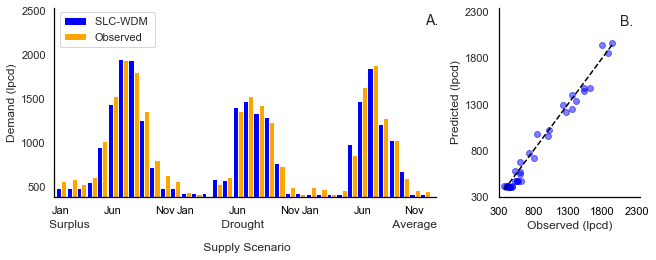

In [13]:
df = pd.DataFrame()
Pred_Obs = Demand_Forecast(slc_val, True, df, 'y_pred_tot', 'y_test_tot', 'lpcd', 'MLR_Seasonal_term_pred_lpcd','SLC-WDM ',
                          'blue', 'orange')

In [14]:
from pandas.tseries.offsets import MonthEnd
cols = ['y_test_tot', 'y_pred_tot']
monthorder = ['Jan', 'Feb' , 'Mar', 'Apr', 'May', 'Jun' , 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Pred_Obs = Pred_Obs[cols]

#input population into DF to calculate total water demands.
Population = []
UR_gpcd = []

slc_pred = copy.deepcopy(slc)

for i in monthorder:
    slc_train[i] = copy.deepcopy(slc[i].loc[:2010])
    slc_pred[i] = slc_pred[i].loc[2015:]
    slc_pred[i]['UR_gpcd'] = np.mean(slc_train[i]['Obs_gpcd'])
    Population.append(np.round(slc_pred[i]['Population'],0))
    
UR=pd.DataFrame()
for i in slc_pred:
    slc_pred[i]= pd.DataFrame(slc_pred[i]['UR_gpcd'])
    slc_pred[i]=slc_pred[i].reset_index()
    slc_pred[i]['M'] = datetime.datetime.strptime(i, "%b").month
    slc_pred[i]['D'] = 1
    slc_pred[i]['Date'] = pd.to_datetime(slc_pred[i].Year*10000+slc_pred[i].M*100+slc_pred[i].D,format='%Y%m%d')+MonthEnd(1)
    slc_pred[i].index = slc_pred[i].Date
    slc_pred[i]=slc_pred[i].drop(columns = ['M', 'D', 'Date', 'Year'])
    UR = UR.append(slc_pred[i])

UR=UR.sort_index()
Population = np.sort(np.array(Population).reshape(36,))

#place in to prediction df
Pred_Obs['Population'] = Population
#add 3.785 to make metric
Pred_Obs['UR_gpcd'] = UR['UR_gpcd']*3.785



#Now we can form some acre-feet predictions.
#volume_conversion = 3.0689e-6 #gallons to acre-feet
volume_conversion = 0.001 #L to m3
daysinmonth = 30

gpcd=['y_test_tot','y_pred_tot','UR_gpcd']
for i in gpcd:
    Pred_Obs[i+str('_AF')] = Pred_Obs[i]*Pred_Obs['Population']*volume_conversion*daysinmonth

    
remcol=['y_test_tot','y_pred_tot','UR_gpcd', 'Population']
Ann_Eval = Pred_Obs.drop(columns = remcol).copy()
Ann_Eval = Ann_Eval.resample('Y').sum()



pdict is not used


<ipython-input-10-00e3ab77e143>:37: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')


Total R2 is  0.9765992771958528
Total MAE is  653661.2436470602
Total RMSE is  767224.8079815292
Total MAPE is  8.41983280606838


<ipython-input-10-00e3ab77e143>:122: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


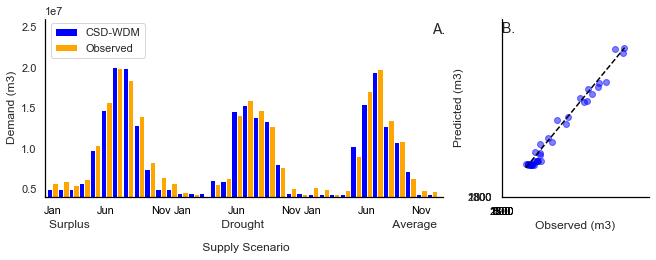

In [15]:
Pred_AF = Demand_Forecast(slc_val, False, Pred_Obs, 
            'y_pred_tot_AF', 'y_test_tot_AF', 'm3', 'MLR_Seasonal_term_pred_AF', 'CSD-WDM', 'blue', 'orange')

pdict is not used


<ipython-input-10-00e3ab77e143>:37: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')


Total R2 is  0.6283371213177069
Total MAE is  238.5911791239317
Total RMSE is  294.97807905990385
Total MAPE is  30.78863740465362


<ipython-input-10-00e3ab77e143>:122: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


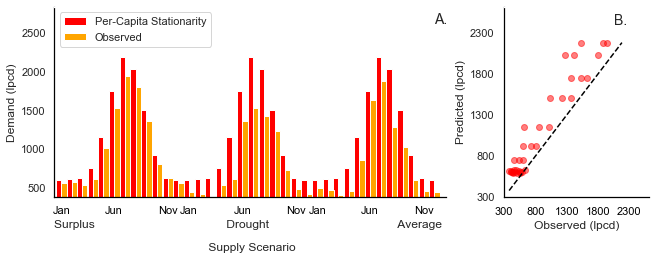

In [16]:
Pred_UR_GPCD = Demand_Forecast(slc_val, False, Pred_Obs, 'UR_gpcd',
                'y_test_tot', 'lpcd', 'Stationary_Demand_Forecast_lpcd', 'Per-Capita Stationarity','red', 'orange')

In [17]:
Pred_UR_GPCD['StationaryError'] = ((Pred_UR_GPCD['UR_gpcd']-Pred_UR_GPCD['y_test_tot'])/Pred_UR_GPCD['y_test_tot'])*100
Pred_UR_GPCD['SLCWDMError'] = ((Pred_UR_GPCD['y_pred_tot']-Pred_UR_GPCD['y_test_tot'])/Pred_UR_GPCD['y_test_tot'])*100
Pred_UR_GPCD['StationaryErrorAF'] = Pred_UR_GPCD['UR_gpcd_AF']-Pred_UR_GPCD['y_test_tot_AF']
Pred_UR_GPCD['SLCWDMErrorAF'] = Pred_UR_GPCD['y_pred_tot_AF']-Pred_UR_GPCD['y_test_tot_AF']
Evalcol = ['y_test_tot_AF', 'y_pred_tot_AF', 'StationaryError','SLCWDMError', 'StationaryErrorAF', 'SLCWDMErrorAF']
Eval = Pred_UR_GPCD[Evalcol]

Annual = Eval.resample('Y').sum()
Annual['S_Perror'] = Annual['StationaryErrorAF']/Annual['y_test_tot_AF']*100
Annual['SLCWDM_Perror'] = Annual['SLCWDMErrorAF']/Annual['y_test_tot_AF']*100
Annual

,y_test_tot_AF,y_pred_tot_AF,StationaryError,SLCWDMError,StationaryErrorAF,SLCWDMErrorAF,S_Perror,SLCWDM_Perror
Date,,,,,,,,
2015-12-31,1.223144e+08,1.149160e+08,139.858017,-112.889766,1.484940e+07,-7.398335e+06,12.140357,-6.048623
2016-12-31,9.931921e+07,9.912215e+07,512.522236,4.603096,3.944983e+07,-1.970593e+05,39.720245,-0.198410
2017-12-31,1.052296e+08,1.017418e+08,455.384862,-48.858969,3.514516e+07,-3.487753e+06,33.398563,-3.314424


In [18]:
#Get monthly stats for UR
URcol = ['y_test_tot', 'UR_gpcd']
Pred_UR_GPCD = Pred_UR_GPCD[URcol]
Pred_UR_GPCD['Month'] = Pred_UR_GPCD.index.month
UR = {}

Irrmon = np.arange(4,11,1)
month = ['Apr', 'May', 'Jun' , 'Jul', 'Aug', 'Sep', 'Oct']
for i in Irrmon:
    UR[i]=Pred_UR_GPCD.loc[Pred_UR_GPCD['Month']==i]
    
for i in UR:
    
    print( calendar.month_name[i], 'Unit Rate Performance Metrics.')
    T_r2 = sklearn.metrics.r2_score(UR[i]['y_test_tot'],UR[i]['UR_gpcd'])
    T_rmse= sklearn.metrics.mean_squared_error(UR[i]['y_test_tot'],UR[i]['UR_gpcd'], squared = False)
    T_mae= sklearn.metrics.mean_absolute_error(UR[i]['y_test_tot'],UR[i]['UR_gpcd'])
    T_mape= sklearn.metrics.mean_absolute_percentage_error(UR[i]['y_test_tot'],UR[i]['UR_gpcd'])*100
        
    print('The Total Demand prediction RMSE is ', T_rmse)
    print('The Total Demand prediction R2 is ', T_r2)
    print('The Total Demand prediction MAE is ', T_mae)
    print('The Total Demand prediction MAPE is ', T_mape, '%') 
    


April Unit Rate Performance Metrics.
The Total Demand prediction RMSE is  234.91850229709772
The Total Demand prediction R2 is  -13.681824813630096
The Total Demand prediction MAE is  226.77711038461538
The Total Demand prediction MAPE is  44.703907893410765 %
May Unit Rate Performance Metrics.
The Total Demand prediction RMSE is  364.68138183793025
The Total Demand prediction R2 is  -3.7219675866079367
The Total Demand prediction MAE is  323.7713262820511
The Total Demand prediction MAPE is  45.51889792211568 %
June Unit Rate Performance Metrics.
The Total Demand prediction RMSE is  272.6448447309825
The Total Demand prediction R2 is  -5.179017266006832
The Total Demand prediction MAE is  249.6095891025643
The Total Demand prediction MAPE is  17.22121622514535 %
July Unit Rate Performance Metrics.
The Total Demand prediction RMSE is  434.639220557867
The Total Demand prediction R2 is  -4.936276355154155
The Total Demand prediction MAE is  396.3433634615385
The Total Demand prediction 

<ipython-input-18-87dd60c0ef69>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pred_UR_GPCD['Month'] = Pred_UR_GPCD.index.month


pdict is not used


<ipython-input-10-00e3ab77e143>:37: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')


Total R2 is  0.6235333383547133
Total MAE is  2485687.106818947
Total RMSE is  3077310.1021666485
Total MAPE is  30.788637404653628


<ipython-input-10-00e3ab77e143>:122: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


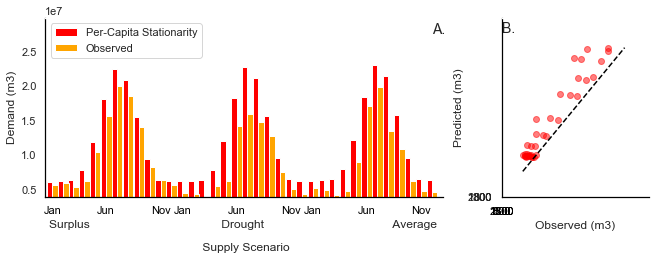

In [19]:
Pred_UR_AF = Demand_Forecast(slc_val, False, Pred_Obs, 'UR_gpcd_AF', 
                             'y_test_tot_AF', 'm3', 'Seasonal_term_pred_UR_AF', 'Per-Capita Stationarity', 'red', 'orange')

In [20]:
'''I am putting a hard code on the limits here to make both figure have same color scale'''

plt.rcParams["axes.grid"] = False
plt.rcParams["axes.facecolor"] ='white'
#plt.rcParams["axes.edgecolor"]['bottom'] = 'black'

def gradientbars_sliced(bars, ymin, ymax):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
 #   ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin= - max(np.abs(ymin), ymax), vmax=max(np.abs(ymin), ymax), cmap='Spectral_r')
    ax.axis([xmin, xmax, ymin, ymax])


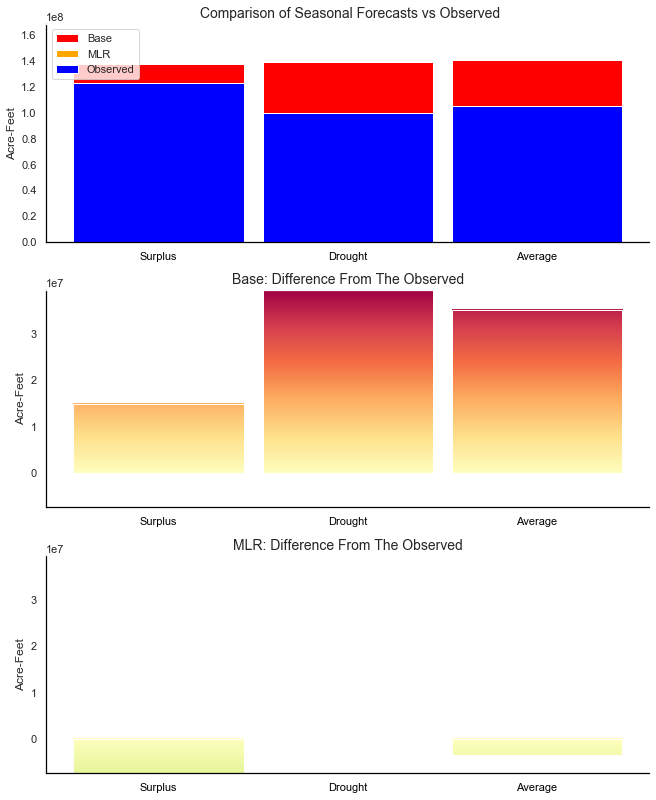

In [21]:
#Reduce width to increase space between bars
width = .9
widthM = 1
titlesize = 14

Ann_Eval['Supply'] = ['Surplus', 'Drought', 'Average']
Ann_Eval.index = Ann_Eval['Supply']

DayDF = Ann_Eval

fig, ax = plt.subplots(3,1, constrained_layout=True)
fig.set_size_inches(9,11)
DayDF['Error_SLC_WDM'] = DayDF.y_pred_tot_AF-DayDF.y_test_tot_AF
DayDF['Error_UR'] = DayDF.UR_gpcd_AF-DayDF.y_test_tot_AF


#Annual Figure

ax[0].bar(DayDF.Supply, DayDF.UR_gpcd_AF, width=width, 
    color='red', label='Base')
ax[0].bar(DayDF.Supply, DayDF.y_pred_tot_AF, width=width, 
    color='orange', label='MLR')
ax[0].bar(DayDF.Supply, DayDF.y_test_tot_AF, width=width, 
    color='blue', label='Observed')
ax[0].set_ylim(0,max(max(Ann_Eval.y_test_tot_AF), max(Ann_Eval.y_pred_tot_AF),max(Ann_Eval.UR_gpcd_AF))*1.2)
#ax.annotate('Max Extra DC use: '+str(np.round(np.max(DayDF.ExtraDC),1))+'MGD', 
 #              xy=(DayDF.index[269], 150))
#ax.annotate('Max Daily DC use: '+str(np.round(np.max(DayDF.SLCDPU_DC_Water_Use),1))+'MGD', 
 #              xy=(DayDF.index[269], 130))
ax[0].legend(loc = 'upper left')
ax[0].set_ylabel('Acre-Feet')
ax[0].set_title(' Comparison of Seasonal Forecasts vs Observed', size = titlesize)
ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')


Error_UR = ax[1].bar(DayDF.index, DayDF.Error_UR, width=width, 
    color='red', label='Base')
ax[1].set_ylabel('Acre-Feet')
ax[1].set_title('Base: Difference From The Observed', size = titlesize)
gradientbars_sliced(Error_UR, min(min(DayDF.Error_UR), min(DayDF.Error_SLC_WDM)),
                    max(max(DayDF.Error_UR), max(DayDF.Error_SLC_WDM)))
ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')



Error_SLC_WDM = ax[2].bar(DayDF.Supply, DayDF.Error_SLC_WDM, width=width, 
    color='red', label='Unit-Rate')
ax[2].set_ylabel('Acre-Feet')
ax[2].set_title('MLR: Difference From The Observed', size = titlesize)
gradientbars_sliced(Error_SLC_WDM, min(min(DayDF.Error_UR), min(DayDF.Error_SLC_WDM)),
                    max(max(DayDF.Error_UR), max(DayDF.Error_SLC_WDM)))
ax[2].spines['bottom'].set_color('black')
ax[2].spines['left'].set_color('black')

fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/SLC_WDMvsUR.pdf')

In [209]:
MLP

{'Apr':             Year     y_pred  y_test  y_test_tot  y_pred_tot      Error  \
 Date                                                                     
 2015-04-30  2008  12.647772   9.222     160.030  138.438436   3.425772   
 2016-04-30  2015  33.293892  26.980     139.970  145.202253   6.313892   
 2017-04-30  2017  10.059749   0.000     120.354  118.001738  10.059749   
 
             Error_tot         MLP  
 Date                               
 2015-04-30 -21.591564  138.438436  
 2016-04-30   5.232253  145.202253  
 2017-04-30  -2.352262  118.001738  ,
 'Aug':             Year      y_pred   y_test  y_test_tot  y_pred_tot      Error  \
 Date                                                                       
 2015-08-31  2008  302.248810  324.702      475.51  428.039474 -22.453190   
 2016-08-31  2015  220.620071  262.590      375.58  332.528433 -41.969929   
 2017-08-31  2017  265.660614  217.536      337.89  373.602603  48.124614   
 
             Error_tot         MLP  

In [22]:
#Make similar figure to one above, but include RFR and MLP.
#Make bars side by side rather than stacked
#need to convert MLP and RFR to metric too
acreft_m3 = 1233.48
MLP = pd.read_excel('MLP_Models/MLP_Ann_Comp.xlsx')
RFR = pd.read_excel('RFR_Models/RFR_Ann_Comp.xlsx')
colrem = ['Supply', 'Supply.1', 'UR_gpcd_AF' ,'Error_UR', 'y_test_tot_AF']
MLP.index = MLP['Supply']
RFR.index = RFR['Supply']
MLP =MLP.drop(columns = colrem)
RFR = RFR.drop(columns = colrem)


MLP_col = ['MLP_pred_tot_AF', 'Error_MLP']
RFR_col = ['RFR_pred_tot_AF', 'Error_RFR']

MLP.columns = MLP_col
RFR.columns = RFR_col

#add mlp and RFR predictions to MLR/Ur
DayDF['RFR_pred'] =RFR['RFR_pred_tot_AF']*acreft_m3
DayDF['RFR_Err'] =RFR['Error_RFR']*acreft_m3

DayDF['MLP_pred'] =MLP['MLP_pred_tot_AF']*acreft_m3
DayDF['MLP_Err'] =MLP['Error_MLP']*acreft_m3

Preds = ['y_test_tot_AF' ,'y_pred_tot_AF', 'MLP_pred', 'RFR_pred', 'UR_gpcd_AF' ]
Err = ['Error_SLC_WDM', 'MLP_Err', 'RFR_Err', 'Error_UR' ]
labels = ['Observed','SLC-WDM' , 'MLP' , 'RFR', 'Stationary']
label2 = ['SLC-WDM' , 'MLP' , 'RFR', 'Stationary']


Preds = DayDF[Preds].copy()
Preds.columns = labels
Err = DayDF[Err].copy()
Err.columns =label2
ErrPerc = Err.copy()

ErrPerc['Stationary'] = round(((Preds['Stationary']-Preds['Observed'])/Preds['Observed'])*100,1)
ErrPerc['SLC-WDM'] = round(((Preds['SLC-WDM']-Preds['Observed'])/Preds['Observed'])*100,1)
ErrPerc['MLP'] = round(((Preds['MLP']-Preds['Observed'])/Preds['Observed'])*100,1)
ErrPerc['RFR'] = round(((Preds['RFR']-Preds['Observed'])/Preds['Observed'])*100,1)


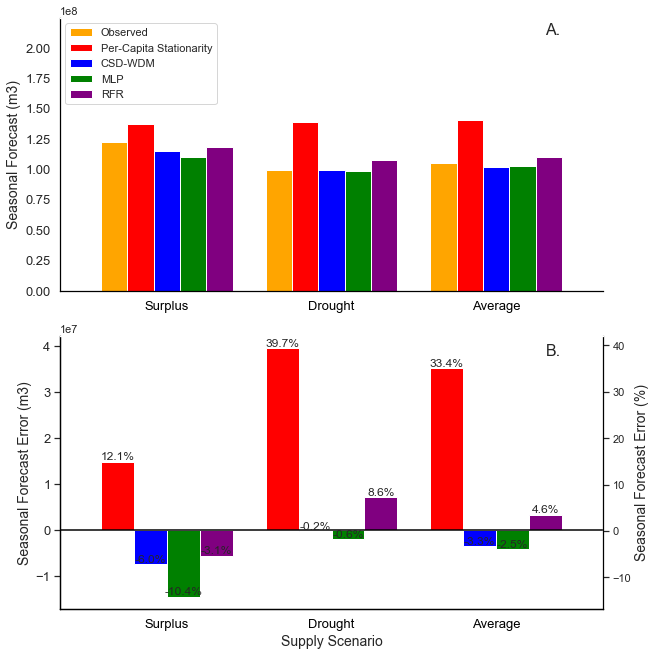

In [23]:
#Reduce width to increase space between bars
width = .8
widthM = 1
titlesize = 14

colorA  = ['orange', 'red', 'blue' ,'green' , 'purple']
colorB  = ['red','blue' ,'green' , 'purple']

colorder = ['Observed', 'Stationary', 'SLC-WDM', 'MLP', 'RFR']
colorder2 = [ 'Stationary', 'SLC-WDM', 'MLP', 'RFR']

Preds = Preds[colorder]
Preds=Preds.rename(columns={"Stationary": "Per-Capita Stationarity", 'SLC-WDM':'CSD-WDM'})

Err = Err[colorder2]
Err=Err.rename(columns={"Stationary": "Per-Capita Stationarity", 'SLC-WDM':'CSD-WDM'})

#del Preds['MLP'], Preds['RFR'], Err['MLP'], Err['RFR']

#colorA  = ['orange', 'red' , 'blue']
#colorB  = ['red' ,'blue']

fig, ax = plt.subplots(2,1, constrained_layout=True)
fig.set_size_inches(9,9)

#Annual Figure

Preds.plot(ax=ax[0], kind='bar', grid=True, width=width, color = colorA)
ax[0].legend(labels)
#ax[0].set_ylim(0,max(max(Ann_Eval.y_test_tot_AF), max(Ann_Eval.y_pred_tot_AF),max(Ann_Eval.UR_gpcd_AF))*1.2)
#ax.annotate('Max Extra DC use: '+str(np.round(np.max(DayDF.ExtraDC),1))+'MGD', 
 #              xy=(DayDF.index[269], 150))
#ax.annotate('Max Daily DC use: '+str(np.round(np.max(DayDF.SLCDPU_DC_Water_Use),1))+'MGD', 
 #              xy=(DayDF.index[269], 130))
ax[0].legend(loc = 'upper left')
ax[0].set_ylabel('Seasonal Forecast (m3)', size = 14)
ax[0].set_ylim(0,np.max(Preds['Per-Capita Stationarity'])*1.6)
#ax[0].set_title(' Comparison of Seasonal Forecasts vs Observed', size = titlesize)
ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')
ax[0].tick_params(labelrotation=0, labelsize = 13)
ax[0].xaxis.label.set_visible(False)
ax[0].text(2.3, np.max(Preds['Per-Capita Stationarity'])*1.5, "A.", size = 16)


Err.plot(ax=ax[1], kind='bar', grid=True, width =width, color=colorB, legend=False)
ax[1].set_ylabel('Seasonal Forecast Error (m3)', size = 14)
#ax[1].set_title('Error', size = titlesize)
ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')
ax[1].tick_params(labelrotation=0, labelsize = 13)
ax[1].axhline(y=0, color='black', linestyle='-')
#ax[1].xaxis.label.set_visible(False)
ax[1].set_xlabel('Supply Scenario', size = 14)
ax[1].text(2.3,38000000, 'B.', size = 16)

ax2 = ax[1].twinx()
ax2.spines['right'].set_position(('axes', 1))
ax2.set_ylim(-16.8,42)
ax2.set_ylabel('Seasonal Forecast Error (%)', size = 14)
ax2.plot(ax=ax2)
ax2.spines['bottom'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.spines['right'].set_color('black')



rects = ax[1].patches

# Make some labels.
labels = list(ErrPerc['Stationary'])+list(ErrPerc['SLC-WDM'])+list(ErrPerc['MLP'])+ list(ErrPerc['RFR'])
#labels = list(ErrPerc['Stationary'])+list(ErrPerc['SLC-WDM'])

for rect, label in zip(rects, labels):
    height = rect.get_height()
    if label > 0:
       # [str(i)+ '%' for i in labels]
        ax[1].text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', size = 12)
    else:
        ax[1].text(rect.get_x() + rect.get_width() / 2, height - 2000, str(label)+'%',
            ha='center', va='bottom', size = 12)




fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/UR_SLCWDM_Demand_compare.pdf')

In [24]:

#Make a function to put all of the predictions together
def Demand_Forecastgpcd_AF(gpcd, pdict, df, pred1, test1,pred2, test2, units1, units2, plotname, model):
    FinalDF=pd.DataFrame()
    if pdict is True:
        print('yes')
        for i in gpcd:
            FinalDF=FinalDF.append(gpcd[i])

        FinalDF=FinalDF.sort_index()
    else:
        print('no')
        FinalDF = df
        
   # months = np.arange(1,6,1)
   # Low = list()
    #Ave=list()
    #High = list()
    #for i in months:
    #    Low.append('Low'+str(i))
    #    Ave.append('Ave'+str(i))
    #    High.append('High'+str(i))
        
    #Low.append('Drought')
    #Ave.append('Average')
    #High.append('Surplus')
    
    #months2 = np.arange(7,13,1)
    #for i in months2:
    #    Low.append('Low'+str(i))
    #    Ave.append('Ave'+str(i))
    #    High.append('High'+str(i))
    
   # Conditions = High+Low+Ave

    #adjust date range to improve figure
    FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')
    #FinalDF['Date'] = Conditions
    
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']

    


    plotmin_tot1 = FinalDF[[pred1, test1]].min().min()
    plotmax_tot1 = FinalDF[[pred1, test1]].max().max()
    
    plotmin_tot2 = FinalDF[[pred2, test2]].min().min()
    plotmax_tot2 = FinalDF[[pred2, test2]].max().max()
    
    Xplotmin = FinalDF.index[0]-np.timedelta64(20, 'D')
    Xplotmax = FinalDF.index[-1]+np.timedelta64(33, 'D')

    fig, ax = plt.subplots(2,6, constrained_layout=True)
    fig.set_size_inches(10,5)

    gs1 = ax[0,0].get_gridspec()
    # remove the underlying axes
    ax[0,0].remove()
    ax[0,1].remove()
    ax[0,2].remove()
    axbig = fig.add_subplot(gs1[0,:3])
    #axbig.set_title('Total demand Timeline Evaluation')
    #axbig.plot(FinalDF[pred1], color='orange', label= model)
    #axbig.plot(FinalDF[test1],color='blue', label='Observed')
    axbig.bar(FinalDF.index-np.timedelta64(7, 'D'), FinalDF[pred1], color='orange', label= 'CSD-WDM',width = 15,  align="center")
    axbig.bar(FinalDF.index+np.timedelta64(8, 'D'), FinalDF[test1], color='blue', label= 'Observed',width = 15,  align="center")
    axbig.set_xlabel('Supply Conditions')
    axbig.set_ylim(plotmin_tot1-.9,plotmax_tot1*1.4)
    axbig.set_xlim(Xplotmin, Xplotmax)
    axbig.set_ylabel('Demand ('+ units1+')')
    axbig.legend(loc = 'upper left', facecolor = 'white')
    axbig.set_facecolor("white")
    axbig.spines['bottom'].set_color('black')
    axbig.spines['left'].set_color('black')
    axbig.tick_params(axis='both', which='both', length=5, color='red')
    axbig.xaxis.set_major_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    axbig.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axbig.annotate('A.', (FinalDF.index[-1], 600), size = 14)
    xticks = axbig.xaxis.get_major_ticks()
    months = [0,5,10,12,17,22,24,29,34]
    
    xticks = axbig.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        #if i%5.5 != 0:
        if i not in months:
            tick.label1.set_visible(False)
   
    
   # xticks = axbig.xaxis.get_major_ticks()
    #for i,tick in enumerate(xticks):
     #   if i%12 != 5:
      #      tick.label1.set_visible(False)

    ax[0,3].remove()
    ax[0,4].remove()
    ax[0,5].remove()


    axbig2 = fig.add_subplot(gs1[0:,3:])
    axbig2.scatter(FinalDF[test1], FinalDF[pred1],color='blue', alpha=0.5)
    axbig2.set_ylabel('Predicted (' + units1+')' )
    axbig2.set_xlabel('Observed (' + units1+')')
    axbig2.set_ylim(plotmin_tot1*.95,plotmax_tot1*1.2)
    axbig2.set_xlim(plotmin_tot1*.95,plotmax_tot1*1.2)
   # axbig2.set_title('Indoor and Outdoor \n Model Performance')
    axbig2.plot([plotmin_tot1,plotmax_tot1],[plotmin_tot1,plotmax_tot1], color='red', linestyle='--' )
    #axbig2.set_xticks(np.arange(plotmin_tot, plotmax_tot, 100).round())
    #axbig2.set_yticks(np.arange(plotmin_tot, plotmax_tot, 100).round())
    axbig2.set_facecolor("white")
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    axbig2.text(550,600, 'C.', size = 16)
    #ax[2].set_aspect('equal', adjustable='box')
    
    
    
    
    gs2 = ax[1,0].get_gridspec()
    # remove the underlying axes
    ax[1,0].remove()
    ax[1,1].remove()
    ax[1,2].remove()
    ax[1,3].remove()
    ax[1,4].remove()
    ax[1,5].remove()
    axbig = fig.add_subplot(gs2[1,:3])
    #axbig.set_title('Total demand Timeline Evaluation')
    #axbig.plot(FinalDF[pred2], color='orange', label= 'Predicted')
    axbig.bar(FinalDF.index-np.timedelta64(7, 'D'), FinalDF[pred2], color='orange', label= 'SLC-WDM',width = 15,  align="center")
    #axbig.plot(FinalDF[test2],color='blue', label='Observed')
    axbig.bar(FinalDF.index+np.timedelta64(8, 'D'), FinalDF[test2], color='blue', label= 'Observed',width = 15,  align="center")    
    axbig.set_xlabel('Supply Conditions')
    axbig.set_ylim(plotmin_tot2-.9,plotmax_tot2*1.2)
    axbig.set_xlim(Xplotmin, Xplotmax)
    axbig.set_ylabel('Demand ('+ units2+')')
    #axbig.legend(loc = 'upper left')
    axbig.set_facecolor("white")
    axbig.spines['bottom'].set_color('black')
    axbig.spines['left'].set_color('black')
    axbig.tick_params(axis='both', which='both', length=5, color='red')
    axbig.xaxis.set_major_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    axbig.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    axbig.annotate('B.', (FinalDF.index[-1], 17000), size = 14)
    xticks = axbig.xaxis.get_major_ticks()
    months = [0,5,10,12,17,22,24,29,34]
    
    xticks = axbig.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        #if i%5.5 != 0:
        if i not in months:
            tick.label1.set_visible(False)
    
    
    #axbig.text(35,17000, 'B.', size = 16)
    #axbig.get_legend().remove()
    
    #xticks = axbig.xaxis.get_major_ticks()
    #for i,tick in enumerate(xticks):
     #   if i%12 != 5:
      #      tick.label1.set_visible(False)
    fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/MLR_Seasonal_gpcd_AFbar.pdf')

no


<ipython-input-24-2319d7f96dc8>:36: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')


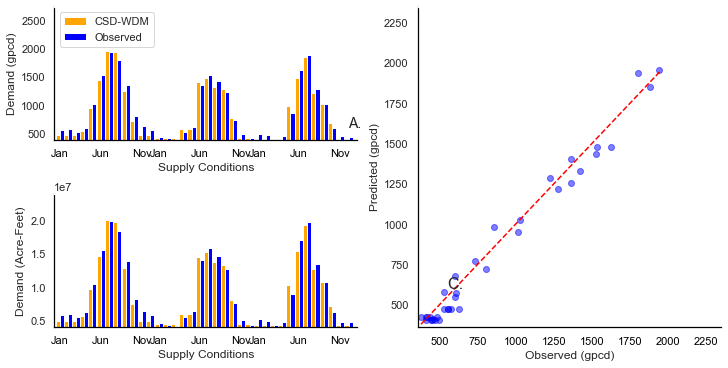

In [25]:
Demand_Forecastgpcd_AF(slc_val, False, Pred_Obs, 
            'y_pred_tot', 'y_test_tot','y_pred_tot_AF', 'y_test_tot_AF', 'gpcd', 'Acre-Feet', 'MLR_Performance', 'CSD-WDM ')

In [26]:

#Make a function to put all of the predictions together
def MultiModelDemand_Forecast(prediction_dictionary, Error, pdict, df, units, plotname):
    FinalDF=pd.DataFrame()
    if pdict is True:
        print('yes')
        for i in prediction_dictionary:
            FinalDF=FinalDF.append(prediction_dictionary[i])

        FinalDF=FinalDF.sort_index()
    else:
        print('pdict is not used')
        FinalDF = df
        
  #  months = np.arange(1,6,1)
  #  Low = list()
   # Ave=list()
   # High = list()
   # for i in months:
    #    Low.append('Low'+str(i))
     #   Ave.append('Ave'+str(i))
      #  High.append('High'+str(i))
        
   # Low.append('Drought')
   # Ave.append('Average')
   # High.append('Surplus')
    
   # months2 = np.arange(7,13,1)
   # for i in months2:
   #     Low.append('Low'+str(i))
   #     Ave.append('Ave'+str(i))
   #     High.append('High'+str(i))
    
   # Conditions = High+Low+Ave
   # print(Conditions)

    #adjust date range to improve figure
    FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')
    #FinalDF['Date'] = FinalDF['Date']-np.timedelta64(14, 'D')
    #FinalDF['Date'] = Conditions
    
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']
    
    #Error or no error
    if Error ==False:
        Observed = FinalDF['Observed']
        SLCWDM = FinalDF['SLCWDM']
        MLP = FinalDF['MLP']
        RFR = FinalDF['RFR']
        Stationary = FinalDF['Per-Capita Stationarity']
    if Error == True:
        SLCWDM = FinalDF['SLCWDM_Error']
        MLP = FinalDF['MLP_Error']
        RFR = FinalDF['RFR_Error']
        Stationary = FinalDF['Stationary_Error']
        
        SLCWDM_MAPE = FinalDF['SLCWDM_Error_MAPE']
        MLP_MAPE = FinalDF['MLP_Error_MAPE']
        RFR_MAPE = FinalDF['RFR_Error_MAPE']
        Stationary_MAPE = FinalDF['Stationary_Error_MAPE']

    
    plotmin_tot = MLP.min()-5
    plotmax_tot = Stationary.max()
    
    plotmin_Perc = MLP_MAPE.min()-5
    plotmax_Perc = Stationary_MAPE.max()
    
    Xplotmin = FinalDF.index[0]-np.timedelta64(20, 'D')
    Xplotmax = FinalDF.index[-1]+np.timedelta64(33, 'D')
    
    plt.rc_context({ 'xtick.color':'black'})
    fig, ax = plt.subplots(2,3, constrained_layout=True)
    fig.set_size_inches(12,9)

    gs = ax[0,2].get_gridspec()
    # remove the underlying axes
    ax[0,0].remove()
    ax[0,1].remove()
    ax[0,2].remove()
    axbig = fig.add_subplot(gs[0,:3])
    axbig.set_facecolor("white")
    #axbig.set_title('Total demand Timeline Evaluation')
    #axbig.bar(FinalDF.index,FinalDF['Observed'], color='blue', width= 15, label='Observed', zorder=1)
    #if Error ==False:
     #   axbig.plot(FinalDF.index,Observed, color='blue', label='Observed', zorder=1)
    axbig.bar(FinalDF.index-np.timedelta64(11, 'D'), SLCWDM, color='blue', label= 'CSD-WDM',width = 7, zorder=3, align="center")
    axbig.bar(FinalDF.index-np.timedelta64(4, 'D'),MLP, color='green', label= 'MLP', width = 7, zorder=2,align="center")
    axbig.bar(FinalDF.index+np.timedelta64(3, 'D'),RFR, color='purple', label= 'RFR',width = 7, zorder=2,align="center")
    axbig.bar(FinalDF.index+np.timedelta64(10, 'D'),Stationary, color='red', label= 'Per-Capita Stationarity', width = 7, zorder=1,align="center")
    axbig.axhline( y = 0, color= 'black')
    
    #axbig.set_xlabel('Surplus                                                                  Drought                                                                 Average \n \n Supply Scenario', size = 16)
    axbig.set_ylim(plotmin_tot*1.2,plotmax_tot*1.2)
    axbig.set_xlim(Xplotmin, Xplotmax)
    axbig.set_ylabel('Prediction Error ('+ units+')', size = 16)
    axbig.legend(loc = 'upper left', facecolor = 'white', fontsize=13)
    axbig.spines['bottom'].set_color('black')
    axbig.spines['left'].set_color('black')
    axbig.tick_params(axis='both', which='both', length=5, color='black')
    axbig.xaxis.set_major_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    axbig.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axbig.tick_params(axis = 'both', labelsize = 14)
    axbig.annotate('A.', (FinalDF.index[-1], plotmax_tot*1.2), size = 16)


    

    #axbig.annotate('A.', (FinalDF.index[-1], 600), size = 14)
    #make a list of desired months
    months = [0,5,10,12,17,22,24,29,34]
    
    xticks = axbig.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        #if i%5.5 != 0:
        if i not in months:
            tick.label1.set_visible(False)
            
    #gs2 = ax[1,2].get_gridspec()
    # remove the underlying axes
    ax[1,0].remove()
    ax[1,1].remove()
    ax[1,2].remove()
    axbig2 = fig.add_subplot(gs[1,:3])
    axbig2.set_facecolor("white")
    #axbig.set_title('Total demand Timeline Evaluation')
    #axbig.bar(FinalDF.index,FinalDF['Observed'], color='blue', width= 15, label='Observed', zorder=1)
    #if Error ==False:
     #   axbig.plot(FinalDF.index,Observed, color='blue', label='Observed', zorder=1)
    axbig2.bar(FinalDF.index-np.timedelta64(11, 'D'), SLCWDM_MAPE, color='blue', label= 'SLC-WDM',width = 7, zorder=3, align="center")
    axbig2.bar(FinalDF.index-np.timedelta64(4, 'D'),MLP_MAPE, color='green', label= 'MLP', width = 7, zorder=2,align="center")
    axbig2.bar(FinalDF.index+np.timedelta64(3, 'D'),RFR_MAPE, color='purple', label= 'RFR',width = 7, zorder=2,align="center")
    axbig2.bar(FinalDF.index+np.timedelta64(10, 'D'),Stationary_MAPE, color='red', label= 'Per-Capita Stationarity', width = 7, zorder=1,align="center")
    axbig2.axhline( y = 0, color= 'black')
    
    axbig2.set_xlabel('Surplus                                                Drought                                               Average \n \n Supply Scenario', size = 16)
    axbig2.set_ylim(plotmin_Perc*.9,plotmax_Perc*1.2)
    axbig2.set_xlim(Xplotmin, Xplotmax)
    axbig2.set_ylabel('Prediction Error (%)', size = 16)
    #axbig2.legend(loc = 'upper left')
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    axbig2.tick_params(axis='both', which='both', length=5, color='black')
    axbig2.xaxis.set_major_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    axbig2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axbig2.tick_params(axis = 'both', labelsize = 14)
    axbig2.annotate('B.', (FinalDF.index[-1], 100), size = 16)


    

    #axbig.annotate('A.', (FinalDF.index[-1], 600), size = 14)
    #make a list of desired months
    months = [0,5,10,12,17,22,24,29,34]
    
    xticks = axbig2.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        #if i%5.5 != 0:
        if i not in months:
            tick.label1.set_visible(False)

            
    
   

    fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' +str(plotname)+'.pdf')
   # r2 = sklearn.metrics.r2_score(FinalDF[test], FinalDF[pred])
    #MAE= sklearn.metrics.mean_absolute_error(FinalDF[test], FinalDF[pred])
    #RMSE= sklearn.metrics.mean_squared_error(FinalDF[test], FinalDF[pred], squared = False)
    #MAPE=np.mean(np.abs((FinalDF[test]- FinalDF[pred])/FinalDF[test])*100)

   # print('Total R2 is ', r2)
   # print('Total MAE is ', MAE)
   # print('Total RMSE is ', RMSE)
   # print('Total MAPE is ', MAPE)
    
 
    return FinalDF

In [27]:
#load mlp and rfr df's to make a predition version to evaluate all model performance
#save predictions
RFR = np.load('RFR_Models/Slc_Pred.npy', allow_pickle = True).item()
#save predictions
MLP = np.load('MLP_Models/Slc_Pred.npy', allow_pickle = True).item()

Model_Comp = copy.deepcopy(slc_pred)

gal_to_m3 = 0.00378541
l_to_m3 = 0.001
#make unique labels for each model
for i in RFR:
    RFR[i]['RFR'] = RFR[i]['y_pred_tot']
    MLP[i]['MLP'] = MLP[i]['y_pred_tot']
    slc_val[i]['SLCWDM'] = slc_val[i]['y_pred_tot']
    slc_val[i]['Observed'] = slc_val[i]['y_test_tot']
    slc_pred[i]['Per-Capita Stationarity'] = slc_pred[i]['UR_gpcd']
    
    
    #align the index on them all, slc-pred already has the updated dates
    RFR[i].index = slc_pred[i].index
    MLP[i].index = slc_pred[i].index
    slc_val[i].index = slc_pred[i].index
    
    #put all into their own dictionaries
    #Observed and SLCWDM already in liters, convert to m3
    Model_Comp[i]['Observed'] = slc_val[i]['Observed']*350000*l_to_m3*30
    Model_Comp[i]['SLCWDM'] = slc_val[i]['SLCWDM']*350000*l_to_m3*30
    Model_Comp[i]['MLP'] = MLP[i]['MLP']*350000*gal_to_m3*30
    Model_Comp[i]['RFR'] = RFR[i]['RFR']*350000*gal_to_m3*30
    Model_Comp[i]['Per-Capita Stationarity'] = slc_pred[i]['Per-Capita Stationarity']*350000*gal_to_m3*30
    
    #Create ML error values
    Model_Comp[i]['SLCWDM_Error'] = Model_Comp[i]['SLCWDM']-Model_Comp[i]['Observed']
    Model_Comp[i]['MLP_Error'] =  Model_Comp[i]['MLP']-Model_Comp[i]['Observed']
    Model_Comp[i]['RFR_Error'] =  Model_Comp[i]['RFR']-Model_Comp[i]['Observed']
    Model_Comp[i]['Stationary_Error'] =  Model_Comp[i]['Per-Capita Stationarity']-Model_Comp[i]['Observed']
    
    Model_Comp[i]['SLCWDM_Error_MAPE'] = (Model_Comp[i]['SLCWDM_Error']/Model_Comp[i]['Observed'])*100
    Model_Comp[i]['MLP_Error_MAPE'] =  (Model_Comp[i]['MLP_Error']/Model_Comp[i]['Observed'])*100
    Model_Comp[i]['RFR_Error_MAPE'] =  (Model_Comp[i]['RFR_Error']/Model_Comp[i]['Observed'])*100
    Model_Comp[i]['Stationary_Error_MAPE'] =  (Model_Comp[i]['Stationary_Error']/Model_Comp[i]['Observed'])*100
    
    
    del Model_Comp[i]['UR_gpcd']




yes


<ipython-input-26-ffa2c52a8a13>:37: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')


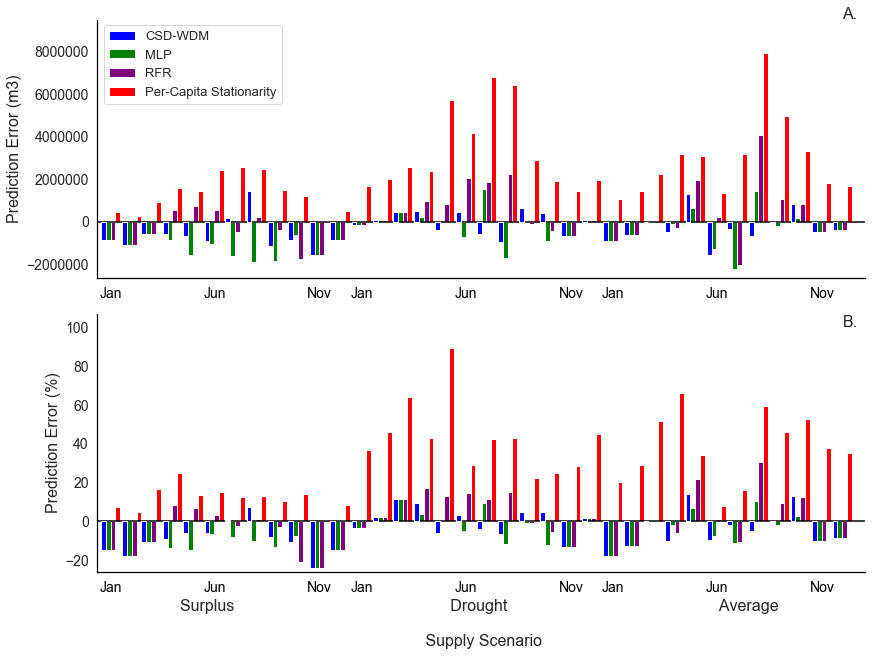

In [28]:
Model_Comparision = MultiModelDemand_Forecast(Model_Comp, True, True, Pred_Obs,  'm3', 'Model_Comparison')